# Base Architecture

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import dateutil

# ------------------ MODEL COMPONENTS ------------------

class TaskSpecificAttention(nn.Module):
    def __init__(self, input_dim):
        super(TaskSpecificAttention, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim)
        self.residual_fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        attention_weights = F.softmax(self.fc(x), dim=-1)
        context_vector = torch.tanh(x * attention_weights)
        return x + self.residual_fc(context_vector)


class SharedGlobalTemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SharedGlobalTemporalAttention, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.final_fc = nn.Linear(hidden_dim, 1)
        self.residual_fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_list):
        combined_hidden = torch.stack([x.mean(dim=1) for x in x_list], dim=1).mean(dim=1)
        tanh_hidden = torch.tanh(self.fc(combined_hidden))
        attention_scores = self.final_fc(tanh_hidden).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=-1).unsqueeze(-1)
        context_vector = combined_hidden * attention_weights
        repeated_context = self.residual_fc(context_vector).unsqueeze(1)
        return [torch.cat((x, repeated_context.repeat(1, x.size(1), 1), x * repeated_context), dim=-1) for x in x_list]


class FATHOMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, window_size=32):
        super(FATHOMModel, self).__init__()
        self.task_attention = TaskSpecificAttention(input_dim)
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 3, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, shared_context):
        x = self.task_attention(x)
        x, _ = self.lstm1(x)
        enriched_context = torch.cat((x, shared_context, x * shared_context), dim=-1)
        x, _ = self.lstm2(enriched_context)
        x = torch.cat((x[:, -1, :], shared_context[:, -1, :]), dim=-1)
        return self.fc2(F.relu(self.fc1(x)))


class MultiTaskFATHOM(nn.Module):
    def __init__(self, num_tasks, input_dim, hidden_dim, output_dim, window_size=32):
        super(MultiTaskFATHOM, self).__init__()
        self.shared_global_attention = SharedGlobalTemporalAttention(hidden_dim)
        self.tasks = nn.ModuleList([
            FATHOMModel(input_dim, hidden_dim, output_dim, window_size) for _ in range(num_tasks)
        ])

    def forward(self, inputs):
        first_stage_outputs = []
        for task_model, x in zip(self.tasks, inputs):
            x, _ = task_model.lstm1(task_model.task_attention(x))
            first_stage_outputs.append(x)

        shared_contexts = self.shared_global_attention(first_stage_outputs)
        return [task_model(x, shared_context) for task_model, x, shared_context in zip(self.tasks, inputs, shared_contexts)]


# ------------------ DATA LOADER ------------------

def df_to_X_y(df, features, target, window_size=32, horizon=1):
    if target not in features:
        features = [target] + features

    data = df[features].to_numpy()
    target_data = df[target].to_numpy()

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(target_data[i + window_size: i + window_size + horizon])

    return np.array(X), np.array(y)


def load_and_preprocess_site_data(site_path, features, target, window_size=32, horizon=1, min_date=None, max_date=None, batch_size=16, device='cpu'):
    df = pd.read_csv(site_path)

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]
        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]
        df.drop(columns=['date'], inplace=True)

    if target not in features:
        features = [target] + features

    all_columns = features
    if not all(col in df.columns for col in all_columns):
        missing = [col for col in all_columns if col not in df.columns]
        raise ValueError(f"Missing columns in dataset: {missing}")

    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    val_size = int(0.2 * len(train_df))
    train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    train_mean, train_std = train_df[all_columns].mean(), train_df[all_columns].std()
    train_df[all_columns] = (train_df[all_columns] - train_mean) / (train_std + 1e-8)
    val_df[all_columns] = (val_df[all_columns] - train_mean) / (train_std + 1e-8)
    test_df[all_columns] = (test_df[all_columns] - train_mean) / (train_std + 1e-8)

    X_train, y_train = df_to_X_y(train_df, features, target, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, features, target, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, features, target, window_size, horizon)

    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader

# ------------------ TRAINING & EVALUATION ------------------

def train_fathom_model(site_loaders, model, optimizer, criterion, scheduler, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_losses, val_losses = [], []
        for task_id, (train_loader, val_loader, _) in enumerate(site_loaders):
            # Training phase
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                preds = model([X])[task_id]
                loss = criterion(preds, y.view(y.size(0), -1))
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_task_losses = []
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    preds_val = model([X_val])[task_id]
                    val_loss = criterion(preds_val, y_val.view(y_val.size(0), -1))
                    val_task_losses.append(val_loss.item())
                val_losses.append(np.mean(val_task_losses))
            model.train()
        scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {np.mean(train_losses):.4f} | Validation Loss: {np.mean(val_losses):.4f}")

    print("Training complete.")


def evaluate_fathom_model(model, site_loaders, device='cpu'):
    model.eval()
    mae_scores = []
    with torch.no_grad():
        for task_id, (_, _, test_loader) in enumerate(site_loaders):
            preds, targets = [], []
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds.append(model([X])[task_id].cpu().numpy())
                targets.append(y.cpu().numpy())
            mae_scores.append(mean_absolute_error(np.concatenate(targets), np.concatenate(preds)))
    print("Evaluation complete.")
    return mae_scores


# Single Task Baseline

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import dateutil
from sklearn.preprocessing import MinMaxScaler

# ------------------ BASELINE SINGLE-TASK MODEL ------------------

class SingleTaskModel(nn.Module):
    """
    Baseline model with NO information sharing between tasks. Each task runs independently.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, window_size=32):
        super(SingleTaskModel, self).__init__()
        self.task_attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Softmax(dim=-1)
        )
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        attention_weights = self.task_attention(x)
        x = x * attention_weights  # Element-wise feature weighting
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Last time step output
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# ------------------ TRAINING & EVALUATION FOR BASELINE ------------------

def train_STL_model(site_loaders, input_dim, hidden_dim, output_dim, num_epochs=5, device='cpu'):
    """
    Trains independent models per site (NO information sharing between tasks).
    """
    num_tasks = len(site_loaders)
    models = [SingleTaskModel(input_dim, hidden_dim, output_dim).to(device) for _ in range(num_tasks)]
    optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        for task_id, (train_loader, val_loader, _) in enumerate(site_loaders):
            models[task_id].train()
            train_losses = []

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                optimizers[task_id].zero_grad()
                preds = models[task_id](X)
                loss = criterion(preds, y.view(y.size(0), -1))
                loss.backward()
                optimizers[task_id].step()
                train_losses.append(loss.item())

            print(f"Epoch {epoch + 1}/{num_epochs} | Task {task_id + 1} | Train Loss: {np.mean(train_losses):.4f}")

    print("Baseline training complete.")
    return models


def evaluate_stl_model(models, site_loaders, device='cpu'):
    """
    Evaluates independent models per site and computes MAE.
    """
    mae_scores = []

    for task_id, (_, _, test_loader) in enumerate(site_loaders):
        models[task_id].eval()
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds = models[task_id](X)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y.cpu().numpy())

        preds_concat = np.concatenate(all_preds, axis=0)
        targets_concat = np.concatenate(all_targets, axis=0)
        mae = mean_absolute_error(targets_concat, preds_concat)
        mae_scores.append(mae)
        print(f"Task {task_id + 1} - Baseline MAE: {mae:.4f}")

    print("Baseline evaluation complete.")
    return mae_scores

In [ ]:
def plot_predictions_vs_ground_truth(model, site_loaders, device='cpu', window_size=32, stride=16):
    """
    Plots the model predictions vs. ground truth for each task using the test DataLoader.
    
    Args:
        model: Trained multi-task model.
        site_loaders: List of tuples (train_loader, val_loader, test_loader) for each site.
        device: "cpu" or "cuda".
        window_size: Sliding window size used during training.
        stride: Plot every 'stride'-th point to reduce clutter.
    """
    model.eval()
    # Extract test loaders from each (train, val, test) tuple
    test_loaders = [loaders[2] for loaders in site_loaders]

    # Collect predictions and ground truth from each task
    all_preds = [[] for _ in range(len(test_loaders))]
    all_truth = [[] for _ in range(len(test_loaders))]

    with torch.no_grad():
        # Zip all test loaders to get one batch per task at each iteration
        for batches in zip(*test_loaders):
            # For each task, extract inputs and targets
            Xs = [batch[0].to(device) for batch in batches]
            ys = [batch[1].to(device) for batch in batches]

            # Forward pass for all tasks
            preds_list = model(Xs)

            # Accumulate predictions and ground truths
            for i in range(len(test_loaders)):
                all_preds[i].append(preds_list[i].cpu().numpy())
                all_truth[i].append(ys[i].cpu().numpy())

    # Now plot for each task
    for i in range(len(test_loaders)):
        # Concatenate along batch dimension and flatten
        preds_i = np.concatenate(all_preds[i], axis=0).flatten()
        truth_i = np.concatenate(all_truth[i], axis=0).flatten()

        # Truncate to the same length, just in case
        min_len = min(len(preds_i), len(truth_i))
        preds_i = preds_i[:min_len]
        truth_i = truth_i[:min_len]

        # Build x-axes
        # Ground truth covers indices [0, 1, 2, ..., min_len-1]
        # Predictions are typically "window_size" steps ahead
        time_axis = np.arange(min_len)
        pred_axis = time_axis + window_size  # shift by window_size

        # Downsample for plotting clarity (optional)
        time_axis_plot = time_axis[::stride]
        truth_plot = truth_i[::stride]
        pred_axis_plot = pred_axis[::stride]
        preds_plot = preds_i[::stride]

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(time_axis_plot, truth_plot, label="Ground Truth", linewidth=1)
        plt.plot(pred_axis_plot, preds_plot, label="Predictions", linewidth=1, linestyle='--')
        plt.title(f"Task {i+1} Predictions vs Ground Truth")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

# Usage

In [6]:
import os
datasets = [
    # {
    #     'ds': 'Solar_feb_22',
    #     'features': ['loc-1', 'loc-2', 'loc-3', 'loc-4'],
    #     'target': 'loc-1',
    #     'base_path': "../processed_ds/solar/",
    #     'min_date': "2006-09-01",
    #     'max_date': "2006-09-08 4:50"
    # },
    # {
    #     'ds': 'Air Quality_feb_22',
    #     'features': ['PM2.5', 'OT', 'PM10', 'NO2'],
    #     'target': 'PM2.5',
    #     'base_path': '../processed_ds/air_quality_cluster',
    #     'min_date': "2014-09-01",
    #     'max_date': "2014-11-12 19:00"
    # },
    {
        'ds': 'Crypto_feb_22',
        'features': ['Open', 'High', 'Low', 'OT', 'Volume'],
        'target': 'OT',
        'base_path': "../processed_ds/crypto-data/",
        'min_date': "2018-04-01",
        'max_date': "2018-06-15"
    },
    # {
    #     'ds': 'Sales_feb_22',
    #     'features': ['OT', 'customers', 'open', 'promo', 'holiday'],
    #     'target': 'OT',
    #     'base_path': "../processed_ds/stores_data/",
    #     'min_date': "2013-01-16",
    #     'max_date': "2015-07-31"
    # }
]

horizons = [16]

for dataset in datasets:
    print(f"\n==================== 🌟 DATASET: {dataset['ds']} ====================")
    for horizon in horizons:
        print(f"\n==================== ⏳ HORIZON: {horizon} ====================")
        
        site_paths = [
            os.path.join(root, file)
            for root, dirs, files in os.walk(dataset['base_path'])
            if root != dataset['base_path']
            for file in files
            if file.endswith(".csv")
        ]

        total_sites = len(site_paths)
        num_tasks = total_sites
        batch_size, window_size, input_dim, hidden_dim, output_dim = 32, 32, len(dataset['features']), 64, horizon

        site_loaders = [
            load_and_preprocess_site_data(
                site_path,
                dataset['features'],
                dataset['target'],
                window_size,
                horizon=output_dim,
                batch_size=batch_size,
                min_date=dataset['min_date'],
                max_date=dataset['max_date']
            ) for site_path in site_paths
        ]

        # Train and evaluate baseline models for comparison
        baseline_stl_models = train_STL_model(site_loaders, input_dim, hidden_dim, output_dim, num_epochs=5, device='cpu')
        baseline_stl_mae = evaluate_stl_model(baseline_stl_models, site_loaders, device='cpu')

        print(f"✅ Completed STL : {dataset['ds']} | Horizon: {horizon} | Baseline MAE per task: {baseline_stl_mae}")
        
        # Train MTL
        mtl_model = train_fathom_model(site_loaders, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_epochs=5, window_size=window_size, device='cpu')
        mtl_scores = evaluate_fathom_model(mtl_model, site_loaders, device="cpu")
        print(f"✅ Completed MTL : {dataset['ds']} | Horizon: {horizon} | MTL MAE per task: {mtl_scores}")

print("\n🏆 All experiments completed successfully!")

In [ ]:
# import os
# import warnings
# warnings.filterwarnings('ignore')

# if __name__ == "__main__":
#     base_path = '../processed_ds/air_quality_cluster'
#     site_paths = [
#         os.path.join(root, file)
#         for root, dirs, files in os.walk(base_path)
#         if root != base_path  # Exclude files in the base directory
#         for file in files
#         if file.endswith(".csv")
#     ]

#     total_sites = len(site_paths)
#     features = ['PM2.5', 'OT', 'PM10', 'NO2']
#     target = 'PM2.5'
#     min_date = "2014-09-01"
#     max_date =  "2014-11-12 19:00"
#     num_tasks = total_sites
#     batch_size, window_size, input_dim, hidden_dim, output_dim = 32, 32, 4, 64, 16

#     model = MultiTaskFATHOM(num_tasks, input_dim, hidden_dim, output_dim, window_size).to("cpu")
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
#     criterion = nn.MSELoss()

#     site_loaders = [load_and_preprocess_site_data(site_path, 
#                                                   features, 
#                                                   target, 
#                                                   window_size, 
#                                                   horizon=output_dim, 
#                                                   batch_size=batch_size, 
#                                                   min_date=min_date,
#                                                   max_date=max_date) for site_path in site_paths]

#     train_fathom_model(site_loaders, model, optimizer, criterion, scheduler, num_epochs=5, device="cpu")
#     mae_scores = evaluate_fathom_model(model, site_loaders, device="cpu")
#     print(f"MAE per task: {mae_scores}")
#     # Plot the predictions vs ground truth for each task
#     plot_predictions_vs_ground_truth(model, site_loaders, device="cpu")

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_5611/1948249427.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/arnobchowdhury/anaconda3/envs/Multiple-time-series/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


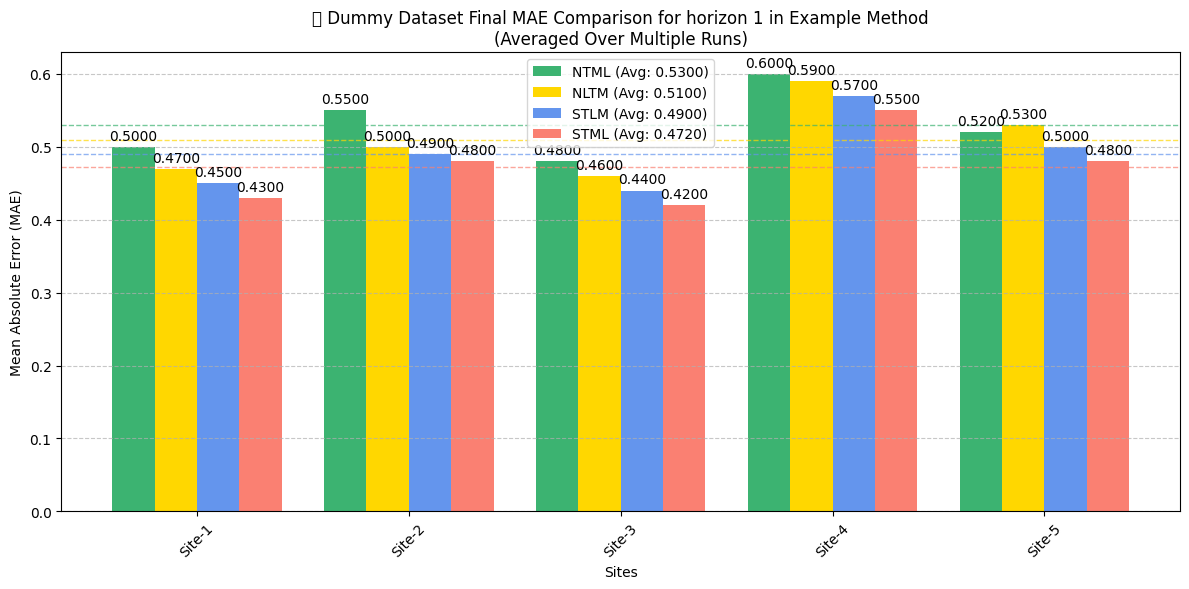

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stl_vs_mtl(ntml_mae, nltm_mae, stlm_mae, stml_mae, 
                     avg_ntml, avg_nltm, avg_stlm, avg_stml, 
                     horizon, method, ds):
    """
    Plots the final average MAE per site for four methods:
    NTML (Non-sharing Transformer Learning), NLTM (Non-sharing LSTM Learning),
    STLM (Sharing Transformer Learning), and STML (Sharing LSTM Learning).

    Args:
        ntml_mae: List or array of MAE scores for NTML per site.
        nltm_mae: List or array of MAE scores for NLTM per site.
        stlm_mae: List or array of MAE scores for STLM per site.
        stml_mae: List or array of MAE scores for STML per site.
        avg_ntml: Average MAE for NTML across all sites.
        avg_nltm: Average MAE for NLTM across all sites.
        avg_stlm: Average MAE for STLM across all sites.
        avg_stml: Average MAE for STML across all sites.
        horizon: Forecast horizon.
        method: Name of the method used.
        ds: Dataset name.
    """
    sites = [f"Site-{i}" for i in range(1, len(ntml_mae) + 1)]
    x = np.arange(len(sites))
    width = 0.2  # width of each bar

    plt.figure(figsize=(12, 6))
    
    # Create bars for each method with appropriate offsets
    bars_ntml = plt.bar(x - 1.5*width, ntml_mae, width, label=f'NTML (Avg: {avg_ntml:.4f})', color='mediumseagreen')
    bars_nltm = plt.bar(x - 0.5*width, nltm_mae, width, label=f'NLTM (Avg: {avg_nltm:.4f})', color='gold')
    bars_stlm = plt.bar(x + 0.5*width, stlm_mae, width, label=f'STLM (Avg: {avg_stlm:.4f})', color='cornflowerblue')
    bars_stml = plt.bar(x + 1.5*width, stml_mae, width, label=f'STML (Avg: {avg_stml:.4f})', color='salmon')

    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Sites')
    plt.title(f'📊 {ds} Final MAE Comparison for horizon {horizon} in {method}\n(Averaged Over Multiple Runs)')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    # Annotate each bar with its height
    for bars in [bars_ntml, bars_nltm, bars_stlm, bars_stml]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Draw horizontal lines for the average MAE for each method
    plt.axhline(y=avg_ntml, color='mediumseagreen', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_nltm, color='gold', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_stlm, color='cornflowerblue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_stml, color='salmon', linestyle='--', linewidth=1, alpha=0.7)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# ---------------------- Dummy Data Example ----------------------

# Let's assume we have data for 5 sites.
ntml_mae = [0.50, 0.55, 0.48, 0.60, 0.52]
nltm_mae = [0.47, 0.50, 0.46, 0.59, 0.53]
stlm_mae = [0.45, 0.49, 0.44, 0.57, 0.50]
stml_mae = [0.43, 0.48, 0.42, 0.55, 0.48]

# Compute average MAE for each method
avg_ntml = np.mean(ntml_mae)
avg_nltm = np.mean(nltm_mae)
avg_stlm = np.mean(stlm_mae)
avg_stml = np.mean(stml_mae)

# Dummy settings for horizon, method, and dataset name
horizon = 1
method = "Example Method"
ds = "Dummy Dataset"

# Plot the dummy data
plot_stl_vs_mtl(ntml_mae, nltm_mae, stlm_mae, stml_mae, 
                avg_ntml, avg_nltm, avg_stlm, avg_stml, 
                horizon, method, ds)


/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_5611/2353883540.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_5611/2353883540.py:73: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'{ds}_STL_vs_MTL_MAE_Comparison_Horizon_{horizon}.png')


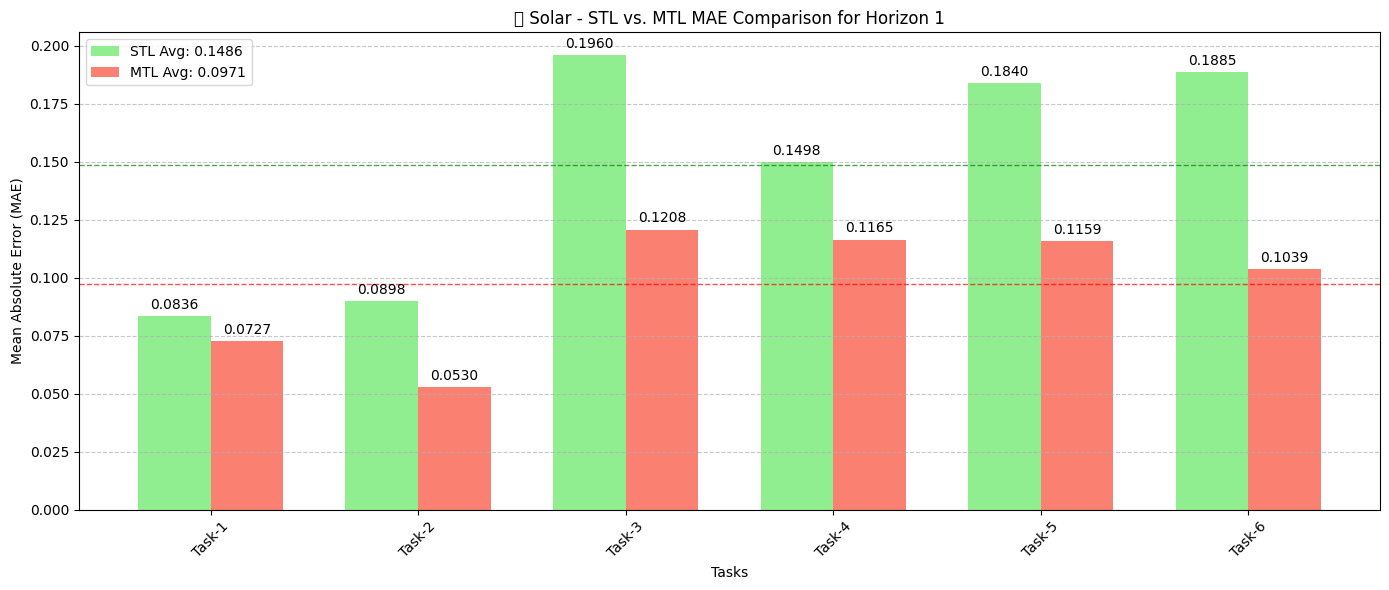

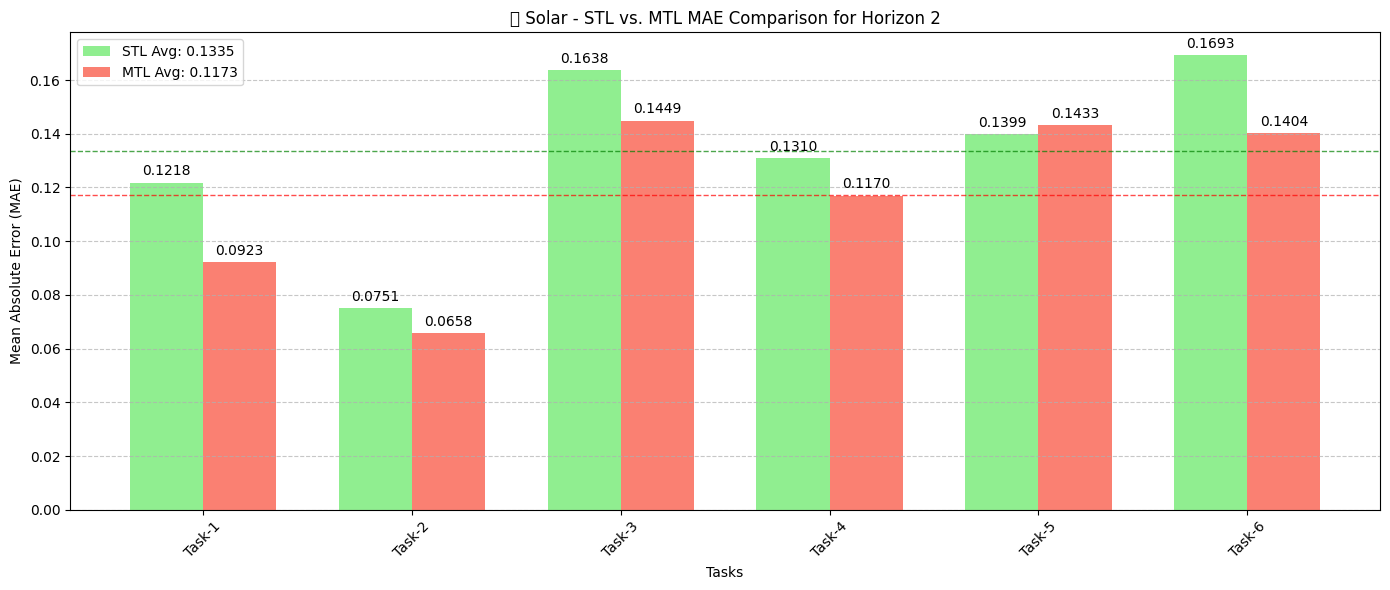

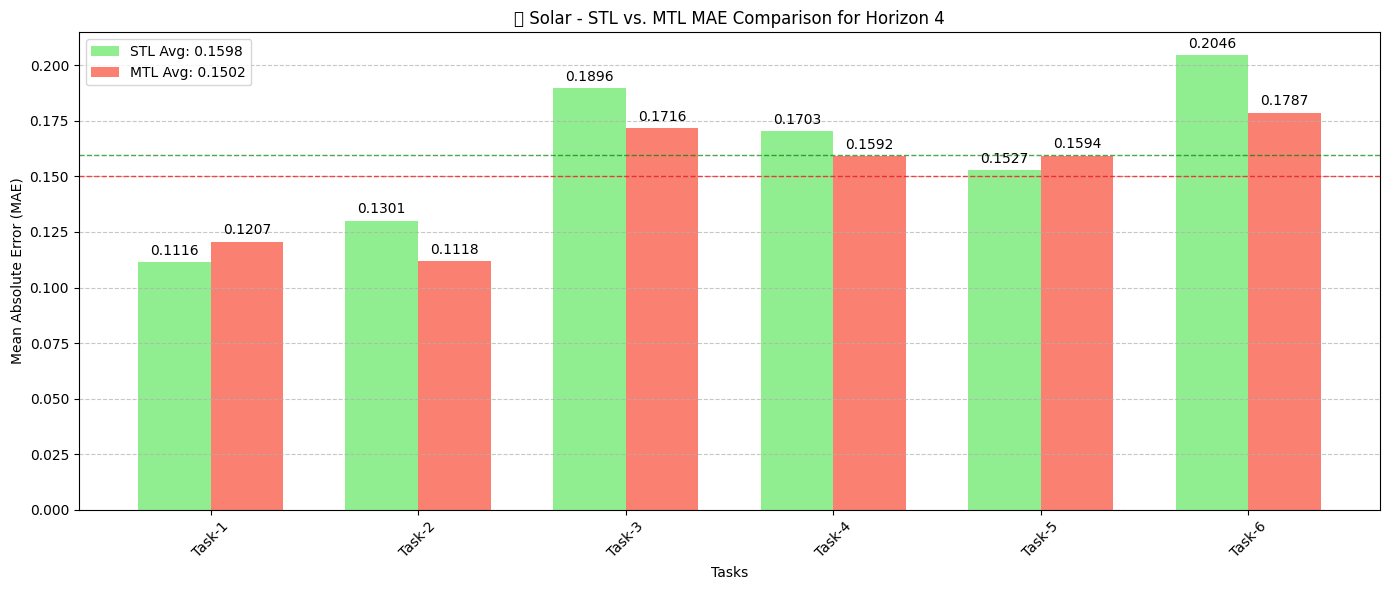

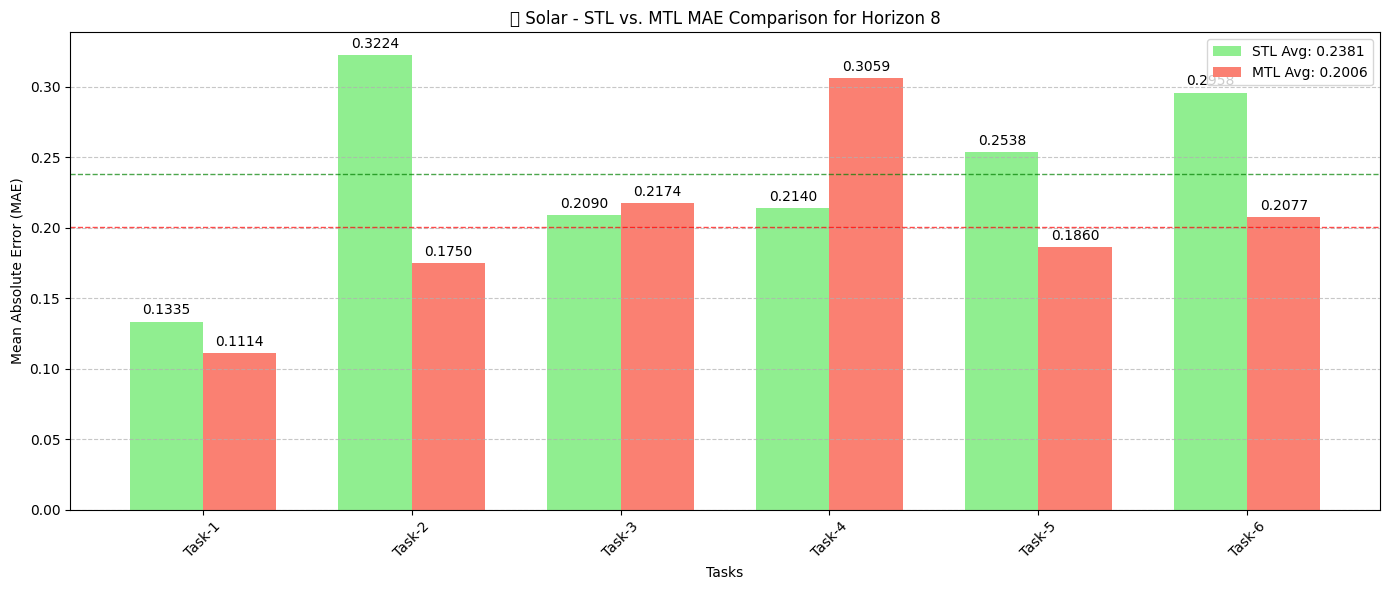

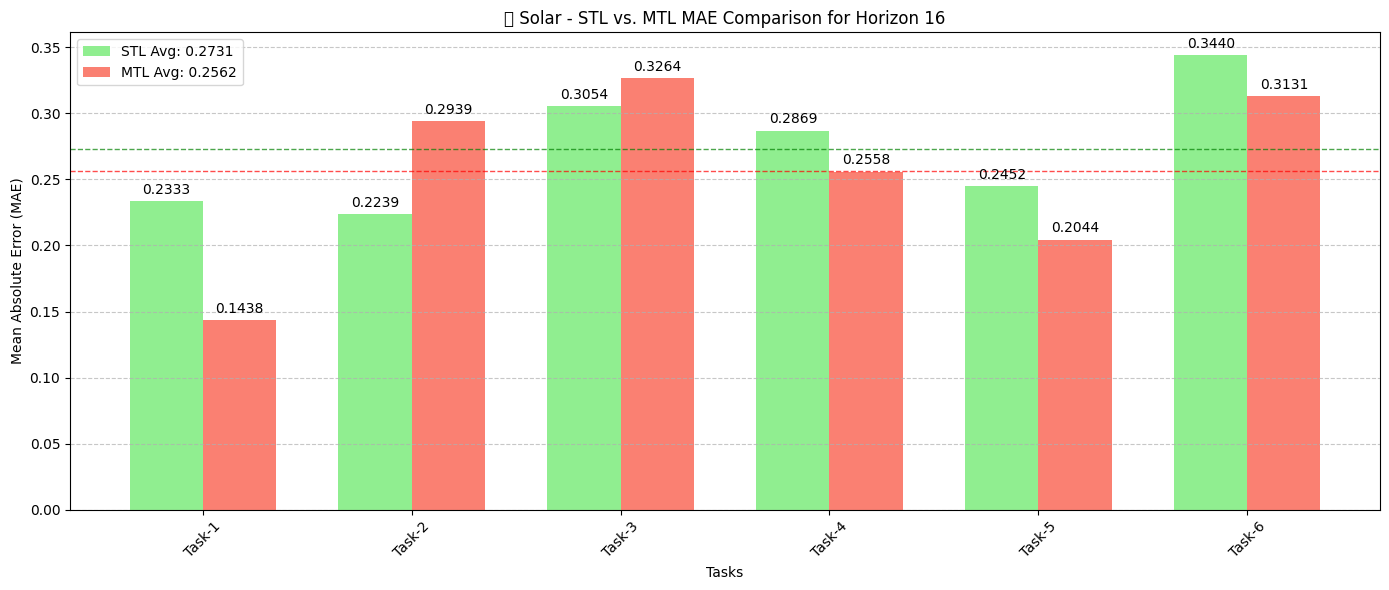

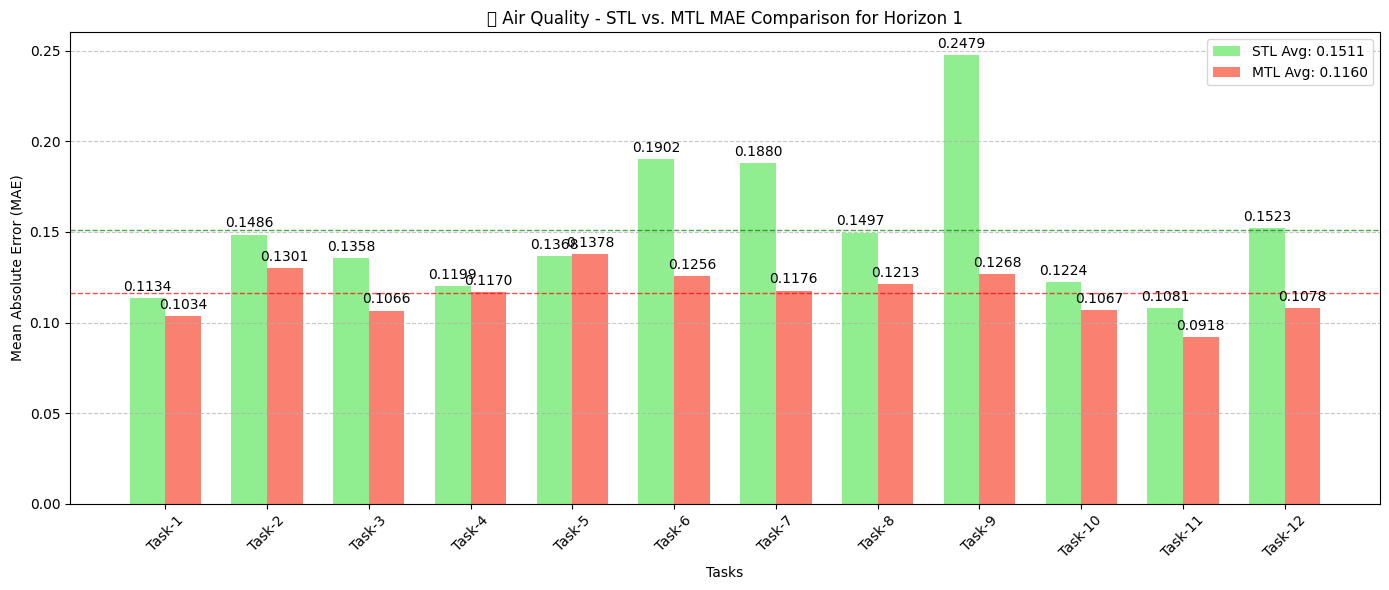

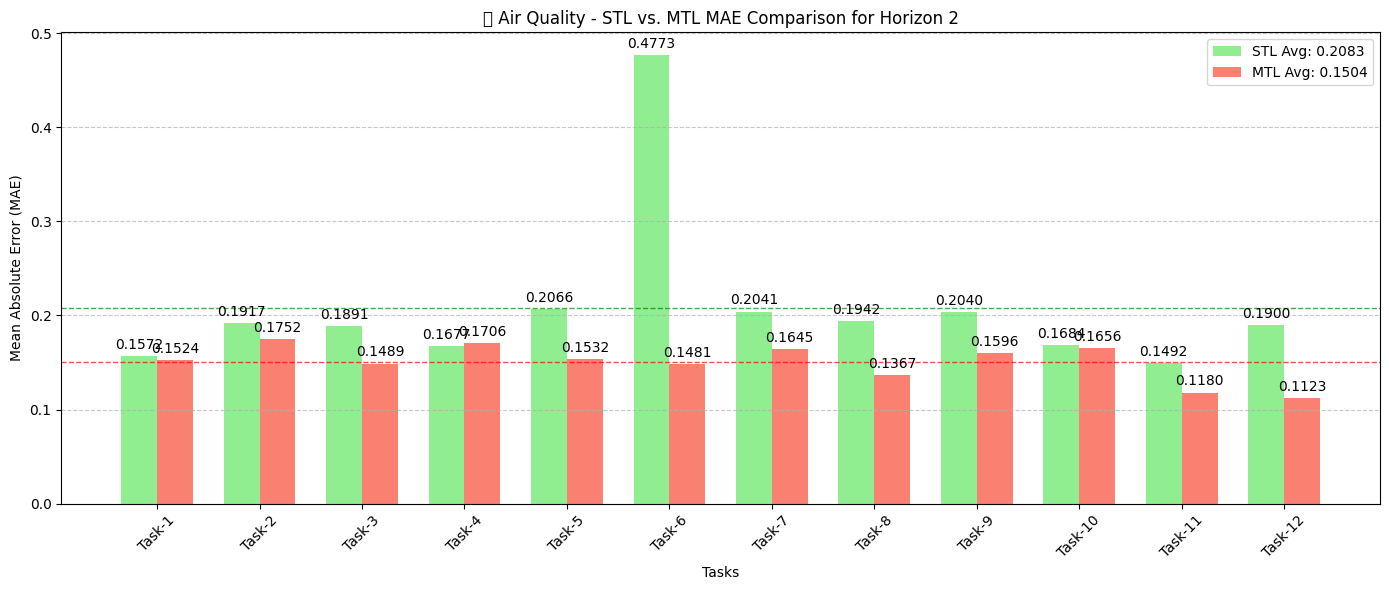

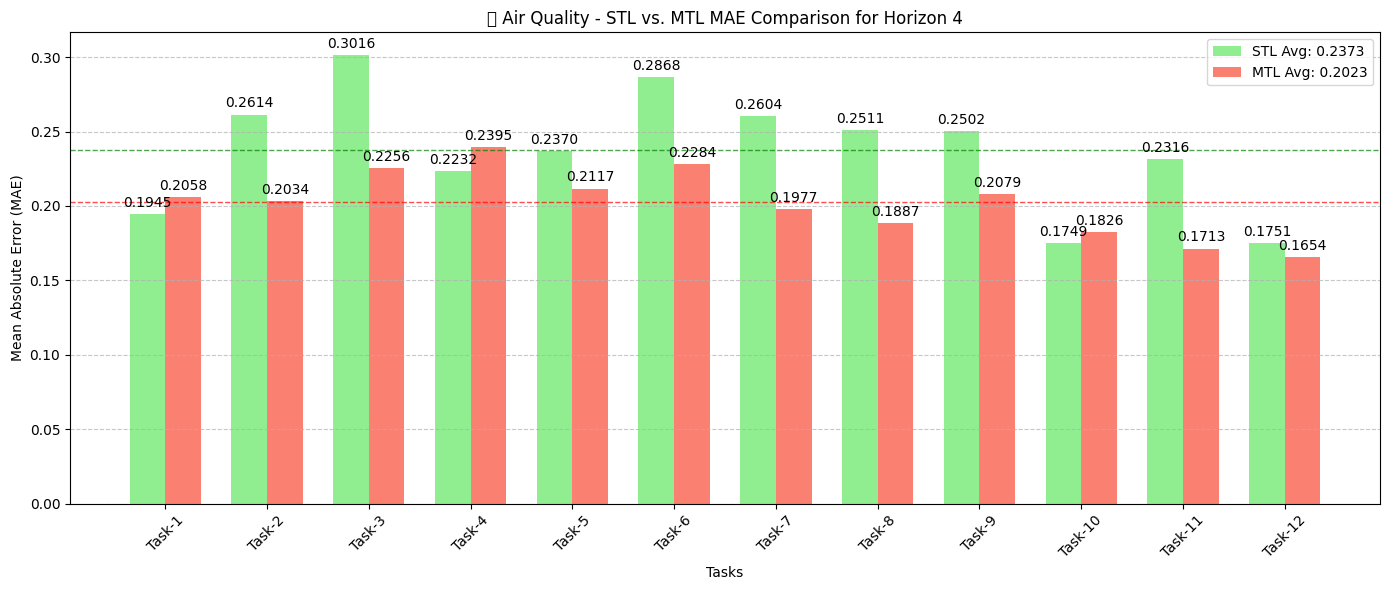

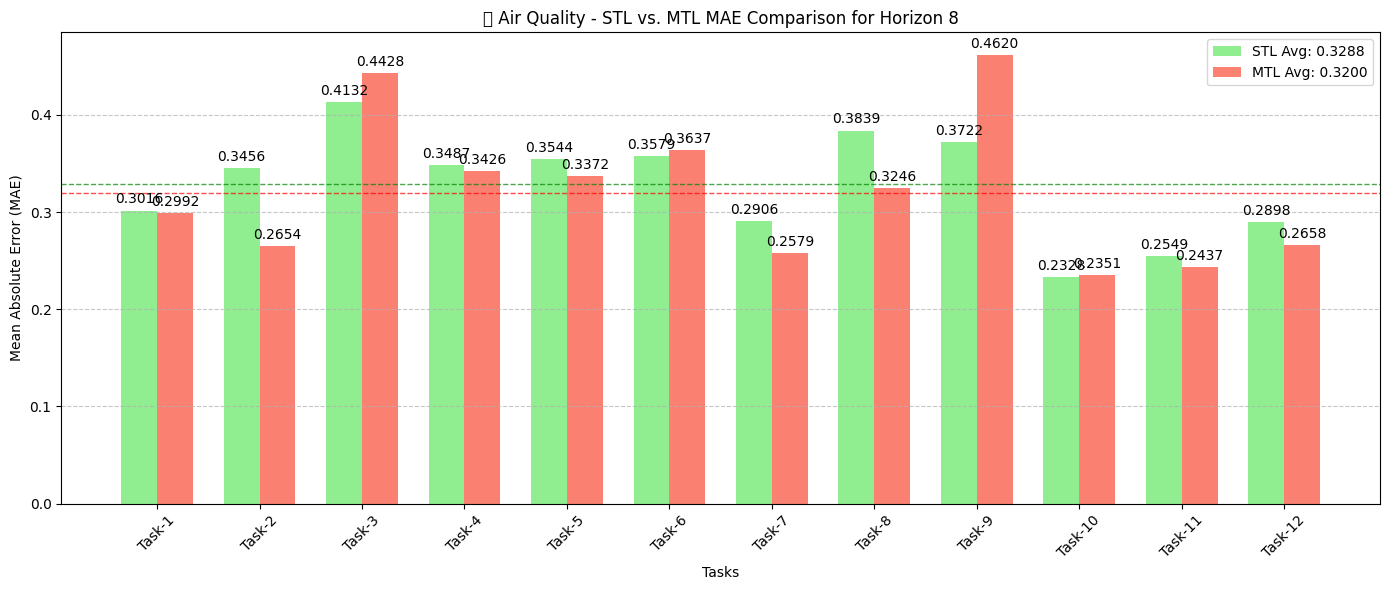

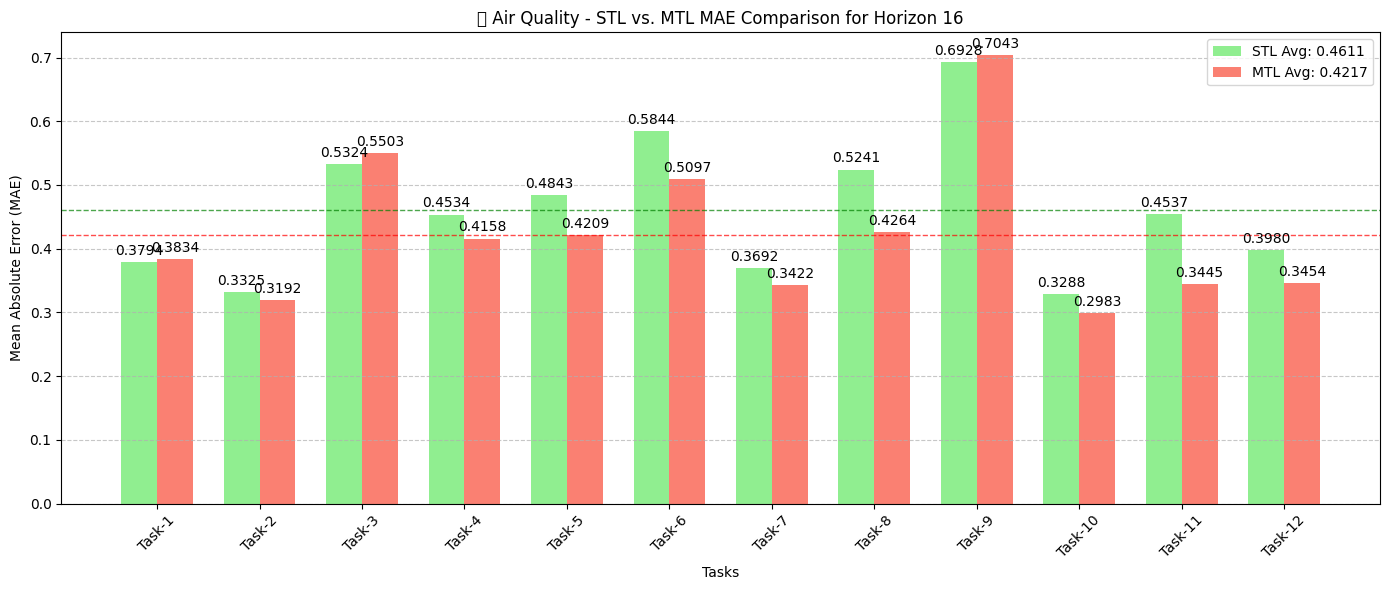

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Sample MAE data for direct execution
data = {
    "Solar": {
        "horizons": [1, 2, 4, 8, 16],
        "stl_mae": [
            [0.0836, 0.0898, 0.1960, 0.1498, 0.1840, 0.1885],
            [0.1218, 0.0751, 0.1638, 0.1310, 0.1399, 0.1693],
            [0.1116, 0.1301, 0.1896, 0.1703, 0.1527, 0.2046],
            [0.1335, 0.3224, 0.2090, 0.2140, 0.2538, 0.2958],
            [0.2333, 0.2239, 0.3054, 0.2869, 0.2452, 0.3440]
        ],
        "mtl_mae": [
            [0.0727, 0.0530, 0.1208, 0.1165, 0.1159, 0.1039],
            [0.0923, 0.0658, 0.1449, 0.1170, 0.1433, 0.1404],
            [0.1207, 0.1118, 0.1716, 0.1592, 0.1594, 0.1787],
            [0.1114, 0.1750, 0.2174, 0.3059, 0.1860, 0.2077],
            [0.1438, 0.2939, 0.3264, 0.2558, 0.2044, 0.3131]
        ]
    },
    "Air Quality": {
        "horizons": [1, 2, 4, 8, 16],
        "stl_mae": [
            [0.1134, 0.1486, 0.1358, 0.1199, 0.1368, 0.1902, 0.1880, 0.1497, 0.2479, 0.1224, 0.1081, 0.1523],
            [0.1572, 0.1917, 0.1891, 0.1677, 0.2066, 0.4773, 0.2041, 0.1942, 0.2040, 0.1684, 0.1492, 0.1900],
            [0.1945, 0.2614, 0.3016, 0.2232, 0.2370, 0.2868, 0.2604, 0.2511, 0.2502, 0.1749, 0.2316, 0.1751],
            [0.3016, 0.3456, 0.4132, 0.3487, 0.3544, 0.3579, 0.2906, 0.3839, 0.3722, 0.2328, 0.2549, 0.2898],
            [0.3794, 0.3325, 0.5324, 0.4534, 0.4843, 0.5844, 0.3692, 0.5241, 0.6928, 0.3288, 0.4537, 0.3980]
        ],
        "mtl_mae": [
            [0.1034, 0.1301, 0.1066, 0.1170, 0.1378, 0.1256, 0.1176, 0.1213, 0.1268, 0.1067, 0.0918, 0.1078],
            [0.1524, 0.1752, 0.1489, 0.1706, 0.1532, 0.1481, 0.1645, 0.1367, 0.1596, 0.1656, 0.1180, 0.1123],
            [0.2058, 0.2034, 0.2256, 0.2395, 0.2117, 0.2284, 0.1977, 0.1887, 0.2079, 0.1826, 0.1713, 0.1654],
            [0.2992, 0.2654, 0.4428, 0.3426, 0.3372, 0.3637, 0.2579, 0.3246, 0.4620, 0.2351, 0.2437, 0.2658],
            [0.3834, 0.3192, 0.5503, 0.4158, 0.4209, 0.5097, 0.3422, 0.4264, 0.7043, 0.2983, 0.3445, 0.3454]
        ]
    }
}

def plot_full_comparison(stl_mae_per_task, mtl_mae_per_task, horizon, ds):
    """
    Plots STL and MTL MAE per task for different horizons and datasets.
    """
    sites = [f"Task-{i+1}" for i in range(len(stl_mae_per_task))]
    x = np.arange(len(sites))
    width = 0.35

    avg_stl = np.mean(stl_mae_per_task)
    avg_mtl = np.mean(mtl_mae_per_task)

    plt.figure(figsize=(14, 6))
    bars_stl = plt.bar(x - width / 2, stl_mae_per_task, width, label=f'STL Avg: {avg_stl:.4f}', color='lightgreen')
    bars_mtl = plt.bar(x + width / 2, mtl_mae_per_task, width, label=f'MTL Avg: {avg_mtl:.4f}', color='salmon')

    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Tasks')
    plt.title(f'📊 {ds} - STL vs. MTL MAE Comparison for Horizon {horizon}')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    for bars in [bars_stl, bars_mtl]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.axhline(y=avg_stl, color='green', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_mtl, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{ds}_STL_vs_MTL_MAE_Comparison_Horizon_{horizon}.png')
    plt.show()

# Run the plots directly for provided data
for dataset, details in data.items():
    for i, horizon in enumerate(details["horizons"]):
        plot_full_comparison(details["stl_mae"][i], details["mtl_mae"][i], horizon, dataset)
